In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scipy
from IPython import display
import seaborn as sns
from scipy import signal
import parkinson_modules as pm
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import matplotlib
from scipy.spatial import transform
# matplotlib.rcParams['text.usetex'] = True
from scipy.signal import butter, welch, filtfilt
warnings.filterwarnings('ignore')
# %matplotlib nbagg
%matplotlib inline
import ahrs

def ewma_filter(data, N = 10):
    swertka = np.zeros(N*10)
    alpha = 2/(N+1)
    data_filt = data.copy()
    swertka[0] = 1
    for i in range(1, N*10):
        swertka[i] = swertka[i-1]*(1 - alpha)
    for i in range(len(data)):
        r_sw = min(len(data) - i , N*10)
        r_data = min(len(data), i + N*10)
    #     print(r_data - i, r_sw)
        data_filt[i] = (data[i:r_data]*swertka[:r_sw]).sum()/swertka[:r_sw].sum()
    return data_filt

def moving_average(arr, N = 200):
    m_a = np.zeros(arr.shape)
    for i in range(arr.shape[0]):
        right = min(i+N, arr.shape[0])
        m_a[i] = arr[i] - arr[i:i+N].mean(axis = 0)
    return m_a

def update_angles(theta, phi, psi, 
                  theta_acc, psi_acc, phi_acc, 
                  phi_gyr, theta_gyr, psi_gyr, i, a = 0.2):
    theta[i] = (1-a)*(theta[i-1] + theta_gyr[i-1]) + theta_acc[i-1]*a
    psi[i]   = (1-a)* (psi[i-1] + psi_gyr[i-1]) + psi_acc[i-1]*a
    phi[i]   = (1-a)* (phi[i-1] + phi_gyr[i-1]) + phi_acc[i-1]*a
    return theta, phi, psi
from numpy import cos 
from numpy import sin
def quarternion(a, b, g):
    w = cos(a)*cos(b)*cos(g) + sin(a)*sin(b)*sin(g)
    x = sin(a)*cos(b)*cos(g) - cos(a)*sin(b)*cos(g)
    y = cos(a)*sin(b)*cos(g) + sin(a)*cos(b)*sin(g)
    z = cos(a)*cos(b)*sin(g) - sin(a)*sin(b)*sin(g)
    return [w,x,y,z]

def RotationMatrixFromQuarternion(q):
    qw,qx,qy,qz = q[0], q[1], q[2], q[3]
    Rot_matrix = np.array(
    [[1 - 2*qy**2 - 2*qz**2,2*qx*qy - 2*qz*qw,2*qx*qz + 2*qy*qw],
    [2*qx*qy + 2*qz*qw,1 - 2*qx**2 - 2*qz**2,2*qy*qz - 2*qx*qw],
    [2*qx*qz - 2*qy*qw,2*qy*qz + 2*qx*qw,1 - 2*qx**2 - 2*qy**2]]
    )
    return Rot_matrix

def rotation_matrix_3d(psi, theta, phi):
    Rot_matrix = np.array([
        [cos(theta)*cos(phi), sin(psi)*sin(theta)*cos(phi)-cos(psi)*sin(phi),  cos(psi)*sin(theta)*cos(phi)+sin(psi)*sin(phi)],
        [cos(theta)*sin(phi), sin(psi)*sin(theta)*sin(phi)+cos(psi)*cos(phi),  cos(psi)*sin(theta)*sin(phi)-sin(psi)*cos(phi)],
        [-sin(theta), sin(psi)*cos(theta),  cos(psi)*cos(theta)]
    ])
    
    return Rot_matrix

In [2]:
def v_(q):
    v = np.array([2*(q[1]*q[3] -  q[0]* q[2]),
    2*( q[0]* q[1] +  q[2]* q[3]),
     q[0]**2 -  q[1]**2 -  q[2]**2 +  q[3]**2])
    return v


def quaternion_multiply(quaternion1, quaternion0):
    w0, x0, y0, z0 = quaternion0
    w1, x1, y1, z1 = quaternion1
    return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)

def q_conjugate(q):
    w, x, y, z = q
    return np.array([w, -x, -y, -z])

class ahrs_imu_class():
    def __init__(self,  Kp = 2, Ki = 0,                     
        KpInit = 200, InitPeriod = 5):
        self.Kp = Kp
        self.Ki = Ki
        self.KpInit = KpInit
        self.InitPeriod = InitPeriod
        self.q = np.array([1, 0, 0, 0]) 
        self.IntError = np.array([0, 0, 0])
    def UpdateIMU(self, Acc, Gyr, Time):
        Acc = Acc/np.linalg.norm(Acc)
        v = v_(self.q)
        error = np.cross(v, Acc)
        self.IntError = self.IntError + error;
        Ref = Gyr - (self.Kp*error + self.Ki*self.IntError)
        pDot = 0.5 * quaternion_multiply(self.q, [0, Ref[0], Ref[1], Ref[2]])
        self.q = self.q + pDot * Time;                                
        self.q = self.q / (0.001  + np.linalg.norm(self.q) )
        return q_conjugate(self.q)
    def reset(self):
        self.IntError = np.zeros(3)
        self.q = np.array([1,0,0,0])

In [3]:
def recontruction(ax, ay, az, gx, gy, gz, time):
    Q = np.tile([1., 0., 0., 0.], (len(ax), 1)) # Allocate an array for all quaternions

    filtCutOff = 0.001
    b, a = butter(1, (2*filtCutOff)/(100), 'highpass')
    acc_mag = np.sqrt(ax*ax + ay*ay + az*az)/1000
    acc_magFilt = filtfilt(b, a, acc_mag)
    acc_magFilt = np.abs(acc_magFilt)
    filtCutOff = 5
    [b, a] = butter(1, (2*filtCutOff)/(100), 'lowpass')
    acc_magFilt = filtfilt(b, a, acc_magFilt)
    stationary = acc_magFilt < 0.05
    ahrs_imu = ahrs_imu_class(Kp=1, Ki = 1)
    ahrs_imu.reset()
    d2g = ahrs.common.DEG2RAD
    for i in range(2000):
        _ = ahrs_imu.UpdateIMU([ax.mean(), ay.mean(), az.mean()], [0, 0, 0], 0.01);

    for t in range(1, len(ax)):
        if stationary[t]:
            ahrs_imu.Kp = 0.5
        else:
            ahrs_imu.Kp = 0
        Q[t] = ahrs_imu.UpdateIMU(np.array([ax[t], ay[t], az[t]]),
                              d2g*np.array([gx[t], gy[t], gz[t]]),
                              time[t] - time[t-1])
    a_rotate = np.zeros((len(ax), 3))

    for i in range(len(ax)):
        RQ = ahrs.common.orientation.q2R(q_conjugate(Q[i]))
        a_rotate[i] = RQ@np.array([ax[i], ay[i], az[i]])
    a_rotate = a_rotate - a_rotate.mean()
    a_rotate = moving_average(a_rotate)
    vel = np.zeros((len(ax), 3))
    for t in range(1, len(ax)):
        vel[t] = vel[t-1] + 0.0098*a_rotate[t] * (time[t] - time[t-1]);
        if (stationary[t] == 1):
            vel[t] = np.array([0, 0, 0]) #  force zero velocity when foot stationary
    diff_stationary = np.array(stationary[1:], dtype = np.int) - np.array(stationary[:-1], dtype = np.int)
    stationaryStart = np.argwhere(diff_stationary == -1)[:, 0]
    stationaryEnd = np.argwhere(diff_stationary == 1)[:,0]
    velDrift = np.zeros(vel.shape)
    
    if stationary[0] == False:
        stationaryEnd = stationaryEnd[1:]
    NNN = min(len(stationaryEnd), len(stationaryStart))
    for i in range(NNN):
        driftRate = vel[stationaryEnd[i]-1] / (stationaryEnd[i] - stationaryStart[i])
        enum = np.arange(1, stationaryEnd[i] - stationaryStart[i])
        drift = np.array([enum*driftRate[0],enum*driftRate[1], enum*driftRate[2]]).T
        velDrift[stationaryStart[i]:stationaryEnd[i]-1] = drift
    vel = vel - velDrift
    pos = np.zeros(vel.shape)
    for t in range(1, len(ax)):
        pos[t] = pos[t-1] + vel[t] * (time[t] - time[t-1])
    return pos

In [4]:
done = []

In [5]:
os.chdir('C:\Files\parkinson')
info = pd.read_excel('Info.xlsx')
info = info.fillna(value = -1)
info.head(5)
os.chdir('C:/Files/parkinson/PatientDataV2/')
path = 'C:/Files/parkinson/PatientDataV2/'
trajectory_dct = {}
file = pd.DataFrame()
list_files = os.listdir()
count = 0
for name in list_files:
    if '.' in name:
        continue
    index = [int(name[7:])]
#     print(name)
    patient_info = info[info['ID'] == index[0]]
    folders = os.listdir(path + name)
    
    for fold in folders:
        trajectory_dct[fold] = {}
        if '.' in fold:
            continue
        if fold in done:
            continue
        print(fold)
        index = list(map(int, fold.split('_')))
        if len(index) == 1:
            index.append(1)
        patient = pm.parkinson(path + name + '/' + fold)
        patient.read(filtering = False)
        for exer_keys in patient.exercises:
#             print(exer_keys)
            exers = patient.exercises[exer_keys]
            ax, ay, az = exers['acc_x, mg' ].values[2:], exers['acc_y, mg' ].values[2:], exers['acc_z, mg' ].values[2:]
            gx, gy, gz = exers['gyr_x, dps'].values[2:], exers['gyr_y, dps'].values[2:], exers['gyr_z, dps'].values[2:]
            timing = patient.time[exer_keys].values[2:]
            
            Acc_mag = np.sqrt(ax**2 + ay**2 + az**2)
            index = np.argwhere(Acc_mag > 0.001)
            xyz = recontruction(ax[index][:,0], ay[index][:,0], az[index][:,0], 
                                gx[index][:,0], gy[index][:,0], gz[index][:,0], 
                                timing[index][:,0])
            trajectory_dct[fold][exer_keys] = xyz
        done.append(fold)
#             break
#         break
#     break


,date,ID,ФИО,пол,возраст,Степень Паркинсона,Травмы/Патологии/Болезни,Баг в эксперименте1,Баг в эксперименте2,index1,index2,Unnamed: 11,postural,kinetic,rest
0,-1,1,Екатерина К,ж,24.0,-1,-1,-1,-1,"1,2,3,4,5,6,7,8,9,-1,10,11,12","1,2,3,4,5,6,7,8,9,-1,10,11,12",-1.0,-1.0,-1.0,-1.0
1,-1,2,Анна Т,ж,23.0,-1,-1,-1,-1,"1,2,3,4,5,6,7,8,9,-1,10,11,12","1,2,3,4,5,6,7,8,9,-1,10,11,12",-1.0,-1.0,-1.0,-1.0
2,-1,3,Александр Т,м,22.0,-1,-1,-1,-1,"1,2,3,4,5,6,7,8,9,-1,10,11,12","1,2,3,4,5,6,7,8,9,-1,10,11,12",-1.0,-1.0,-1.0,-1.0
3,-1,4,Иван Д,м,24.0,-1,-1,-1,-1,"1,2,3,4,5,6,7,8,9,-1,10,11,12","1,2,3,4,5,6,7,8,9,-1,10,11,12",-1.0,-1.0,-1.0,-1.0
4,-1,5,Дмитрий Е,м,24.0,-1,-1,-1,-1,"1,2,3,4,5,6,7,8,9,-1,10,11,12","1,2,3,4,5,6,7,8,9,-1,10,11,12",-1.0,-1.0,-1.0,-1.0


In [6]:
os.chdir('C:/Files/parkinson/PatientDataV2/')
path = 'C:/Files/parkinson/PatientDataV2/'
trajectory_dct = {}
file = pd.DataFrame()
list_files = os.listdir()
count = 0
for name in list_files:
    if '.' in name:
        continue
    index = [int(name[7:])]
#     print(name)
    patient_info = info[info['ID'] == index[0]]
    folders = os.listdir(path + name)
    
    for fold in folders:
        trajectory_dct[fold] = {}
        if '.' in fold:
            continue
        if fold in done:
            continue
        print(fold)
        index = list(map(int, fold.split('_')))
        if len(index) == 1:
            index.append(1)
        patient = pm.parkinson(path + name + '/' + fold)
        patient.read(filtering = False)
        for exer_keys in patient.exercises:
#             print(exer_keys)
            exers = patient.exercises[exer_keys]
            ax, ay, az = exers['acc_x, mg' ].values[2:], exers['acc_y, mg' ].values[2:], exers['acc_z, mg' ].values[2:]
            gx, gy, gz = exers['gyr_x, dps'].values[2:], exers['gyr_y, dps'].values[2:], exers['gyr_z, dps'].values[2:]
            timing = patient.time[exer_keys].values[2:]
            
            Acc_mag = np.sqrt(ax**2 + ay**2 + az**2)
            index = np.argwhere(Acc_mag > 0.001)
            xyz = recontruction(ax[index][:,0], ay[index][:,0], az[index][:,0], 
                                gx[index][:,0], gy[index][:,0], gz[index][:,0], 
                                timing[index][:,0])
            trajectory_dct[fold][exer_keys] = xyz
        done.append(fold)
#             break
#         break
#     break


01
01_2
02
02_2
03
03_2
04
04_2
05
05_2
06
06_2
07
07_2
08
08_2
09
09_2
10
10_2
11
11_2
12
12_2
13
13_2
14
14_2
15
15_2
16
16_2
17
17_02
18
18_02
19
19_02
20
20_2
21
22
22_2
23
23_2
24
24_2
25
25_2
26
27
28
28_2
29
broken_ex14_29.csv 
 !!ERROR!!
30
31
32
broken_ex13_32.csv 
 !!ERROR!!
32_2
33
33_2
34
35
36
37
38
39
40
41
41_2
42
42_2
43
43_2
44
45_2
46
47
48
49
50
51
52
53
53_2
54
54_2
55
55_2
56
56_2
57
57_2
58
59
60
62
63
63_2
64
65
66
67
68
69


In [8]:
with open('C:/Files/parkinson/trajectory_per_person', 'wb') as config_dictionary_file:
    pickle.dump(trajectory_dct, config_dictionary_file)

In [13]:
trajectory_per_exer_per_person = {}

In [14]:
for person in trajectory_dct:
    for exer in trajectory_dct[person]:
        if exer not in trajectory_per_exer_per_person:
            trajectory_per_exer_per_person[exer] = {}
        trajectory_per_exer_per_person[exer][person] = trajectory_dct[person][exer]

KeyError: '11_2'

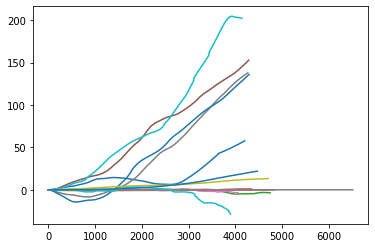

In [30]:
trajectory_array_per_exercise = {}
for exer in trajectory_per_exer_per_person:
#     if exer not in trajectory_per_exer_per_person:
#         trajectory_array_per_exercise[exer] = 
    
    for person in trajectory_per_exer_per_person[exer]:
        plt.plot(trajectory_per_exer_per_person[11][person][:,2])
    
    break

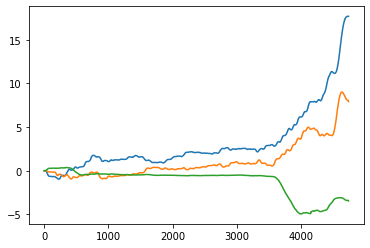

In [37]:
plt.plot(trajectory_per_exer_per_person[11]['02'])
pos1 = trajectory_per_exer_per_person[11]['02']

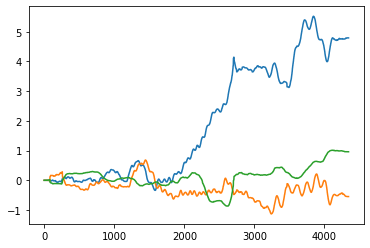

In [78]:
plt.plot(trajectory_per_exer_per_person[11]['02_2'])
# plt.plot(trajectory_per_exer_per_person[11]['03'])

# plt.plot(trajectory_per_exer_per_person[11]['12'])
# plt.plot(trajectory_per_exer_per_person[11]['22'])
# plt.plot(trajectory_per_exer_per_person[11]['32'])
# plt.plot(trajectory_per_exer_per_person[11]['42'])



# pos2 = trajectory_per_exer_per_person[11]['02_2']

In [35]:
from fastdtw import fastdtw


In [41]:
dst = fastdtw(pos1, pos2)

In [44]:
pos1 = trajectory_per_exer_per_person[10]['01']

In [48]:
dist_the_same = []
dist_the_diff = []

for key in trajectory_per_exer_per_person[10]:
    dist_the_same.append(fastdtw(pos1, trajectory_per_exer_per_person[10][key]))
for key in trajectory_per_exer_per_person[11]:
    print(key)
    dist_the_diff.append(fastdtw(pos1, trajectory_per_exer_per_person[11][key]))


01
01_2
02
02_2
03
03_2
04
04_2
05
05_2
06
06_2
07
07_2
08
08_2
09
09_2
10
10_2
11
12
12_2
13
13_2
14
14_2
15
15_2
16
16_2
17
17_02
18
18_02
19
19_02
20
20_2
21
22
22_2
23
23_2
24
24_2
25
25_2
26
27
28
28_2
29
30
31
32
32_2
33
33_2
34
35
36
37
38
39
40
41
41_2
42
42_2
43
43_2
44
45_2
46
47
48
49
50
51
52
53
53_2
54
54_2
55
55_2
56
56_2
57
57_2
58
59
60
62
63
63_2
64
65
66
67
68
69


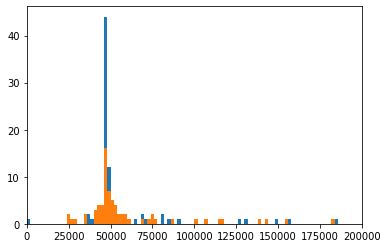

In [67]:
plt.hist(dist_the_same, bins = 100, range = (0, 200000))
plt.hist(dist_the_diff, bins = 100, range = (0, 200000))
plt.xlim(0, 200000)
plt.show()

(array([70., 12.,  6.,  4.,  5.,  2.,  2.,  1.,  0.,  1.]),
 array([  25348.87667422,  183011.04162586,  340673.20657751,
         498335.37152915,  655997.5364808 ,  813659.70143244,
         971321.86638409, 1128984.03133573, 1286646.19628738,
        1444308.36123902, 1601970.52619067]),
 <a list of 10 Patch objects>)

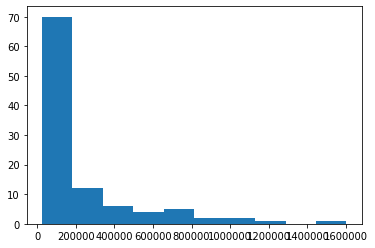

In [61]:
plt.hist(dist_the_diff)

In [59]:
# dist_the_same = [dist[0] for dist in dist_the_same]
# dist_the_diff = [dist[0] for dist in dist_the_diff]

IndexError: invalid index to scalar variable.

In [57]:
dits_the_diff

NameError: name 'dits_the_diff' is not defined

In [31]:
file = pd.read_csv('C:/Files/parkinson/PatientDataV2/patient58/58/ex14_58.csv')

ax, ay, az = file['acc_y, mg'].values[2:], file['acc_z, mg'].values[2:], file['acc_x, mg'].values[2:]
gx, gy, gz = file['gyr_y, dps'].values[2:], file['gyr_z, dps'].values[2:], file['gyr_x, dps'].values[2:]
mx, my, mz = file['mag_y, mga'].values[2:], file['mag_z, mga'].values[2:], file['mag_x, mga'].values[2:]
time = file['time, s'].values[2:]

Acc_mag = np.sqrt(ax**2 + ay**2 + az**2)
index = np.argwhere(Acc_mag > 0.001)

In [32]:
# recontruction(ax[index], ay[index], az[index], gx[index], gy[index], gz[index], time[index])

In [54]:

# ax, ay, az = file['acc_y, mg'].values[2:], file['acc_z, mg'].values[2:], file['acc_x, mg'].values[2:]
# gx, gy, gz = file['gyr_y, dps'].values[2:], file['gyr_z, dps'].values[2:], file['gyr_x, dps'].values[2:]
# mx, my, mz = file['mag_y, mga'].values[2:], file['mag_z, mga'].values[2:], file['mag_x, mga'].values[2:]
# time = file['time, s'].values[2:]
# ax,ay,az = ax[index][:,0],ay[index][:,0],az[index][:,0]
# gx,gy,gz = gx[index][:,0],gy[index][:,0],gz[index][:,0]
# time = time[index][:,0]
print(ax.shape)
Q = np.tile([1., 0., 0., 0.], (len(ax), 1)) # Allocate an array for all quaternions

filtCutOff = 0.001
b, a = butter(1, (2*filtCutOff)/(100), 'highpass')
acc_mag = np.sqrt(ax*ax + ay*ay + az*az)/1000
print(acc_mag.shape, len(b), len(a))
acc_magFilt = filtfilt(b, a, acc_mag)
acc_magFilt = np.abs(acc_magFilt)
filtCutOff = 5
[b, a] = butter(1, (2*filtCutOff)/(100), 'lowpass')
acc_magFilt = filtfilt(b, a, acc_magFilt)
stationary = acc_magFilt < 0.05
ahrs_imu = ahrs_imu_class(Kp=1, Ki = 1)
ahrs_imu.reset()
d2g = ahrs.common.DEG2RAD
for i in range(2000):
    _ = ahrs_imu.UpdateIMU([ax.mean(), ay.mean(), az.mean()], [0, 0, 0], 0.01);

for t in range(1, len(ax)):
    if stationary[t]:
        ahrs_imu.Kp = 0.5
    else:
        ahrs_imu.Kp = 0
    Q[t] = ahrs_imu.UpdateIMU(np.array([ax[t], ay[t], az[t]]),
                          d2g*np.array([gx[t], gy[t], gz[t]]),
                          time[t] - time[t-1])
a_rotate = np.zeros((len(ax), 3))

for i in range(len(ax)):
    RQ = ahrs.common.orientation.q2R(q_conjugate(Q[i]))
    a_rotate[i] = RQ@np.array([ax[i], ay[i], az[i]])
a_rotate = a_rotate - a_rotate.mean()
a_rotate = moving_average(a_rotate)
vel = np.zeros((len(ax), 3))
for t in range(1, len(ax)):
    vel[t] = vel[t-1] + 0.0098*a_rotate[t] * (time[t] - time[t-1]);
    if (stationary[t] == 1):
        vel[t] = np.array([0, 0, 0]) #  force zero velocity when foot stationary
diff_stationary = np.array(stationary[1:], dtype = np.int) - np.array(stationary[:-1], dtype = np.int)
stationaryStart = np.argwhere(diff_stationary == -1)[:, 0]
stationaryEnd = np.argwhere(diff_stationary == 1)[:,0]
velDrift = np.zeros(vel.shape)
if stationary[0] == False:
    stationaryEnd = stationaryEnd[1:]
NNN = min(len(stationaryEnd), len(stationaryStart))
print(NNN)

for i in range(NNN):
    driftRate = vel[stationaryEnd[i]-1] / (stationaryEnd[i] - stationaryStart[i])
    enum = np.arange(1, stationaryEnd[i] - stationaryStart[i])
    drift = np.array([enum*driftRate[0],enum*driftRate[1], enum*driftRate[2]]).T
    velDrift[stationaryStart[i]:stationaryEnd[i]-1] = drift
vel = vel - velDrift
pos = np.zeros(vel.shape)
for t in range(1, len(ax)):
    pos[t] = pos[t-1] + vel[t] * (time[t] - time[t-1])

(1154,)
(1154,) 2 2
41


In [8]:
Q = np.tile([1., 0., 0., 0.], (len(ax), 1)) # Allocate an array for all quaternions

filtCutOff = 0.001
b, a = butter(1, (2*filtCutOff)/(100), 'highpass')
acc_mag = np.sqrt(ax*ax + ay*ay + az*az)/1000

acc_magFilt = filtfilt(b, a, acc_mag)
acc_magFilt = np.abs(acc_magFilt)
filtCutOff = 5
[b, a] = butter(1, (2*filtCutOff)/(100), 'lowpass')
acc_magFilt = filtfilt(b, a, acc_magFilt)
stationary = acc_magFilt < 0.05
ahrs_imu = ahrs_imu_class(Kp=1, Ki = 1)
ahrs_imu.reset()
d2g = ahrs.common.DEG2RAD
for i in range(2000):
    _ = ahrs_imu.UpdateIMU([ax.mean(), ay.mean(), az.mean()], [0, 0, 0], 0.01);


In [64]:

for t in range(1, len(ax)):
    if stationary[t]:
        ahrs_imu.Kp = 0.5
    else:
        ahrs_imu.Kp = 0
    Q[t] = ahrs_imu.UpdateIMU(np.array([ax[t], ay[t], az[t]]),
                          d2g*np.array([gx[t], gy[t], gz[t]]),
                          time[t] - time[t-1])
a_rotate = np.zeros((len(ax), 3))

In [9]:
ahrs_imu.q

array([ 9.81725737e-01,  1.49328734e-01, -1.09162755e-01, -3.15479549e-16])

In [14]:
t = 1
Acc = np.array([ax[t], ay[t], az[t]])
Gyr = np.array([gx[t], gy[t], gz[t]])
Time = time[t]- time[t-1]
Acc = Acc/np.linalg.norm(Acc)
v = v_(ahrs_imu.q)
error = np.cross(v, Acc)
ahrs_imu.IntError = ahrs_imu.IntError + error;
Ref = Gyr - (ahrs_imu.Kp*error + ahrs_imu.Ki*ahrs_imu.IntError)
pDot = 0.5 * quaternion_multiply(ahrs_imu.q, [0, Ref[0], Ref[1], Ref[2]])
q = ahrs_imu.q + pDot * Time;                                
q = ahrs_imu.q / (0.001  + np.linalg.norm(ahrs_imu.q) )

In [17]:
Acc = np.array([ax[t], ay[t], az[t]])


In [19]:
ax,ay,az

(array([  0.,   0.,   0., ..., 294., 309., 326.]),
 array([  0.,   0.,   0., ..., 146., 160., 177.]),
 array([  0.,   0.,   0., ..., 967., 969., 978.]))

<IPython.core.display.Javascript object>


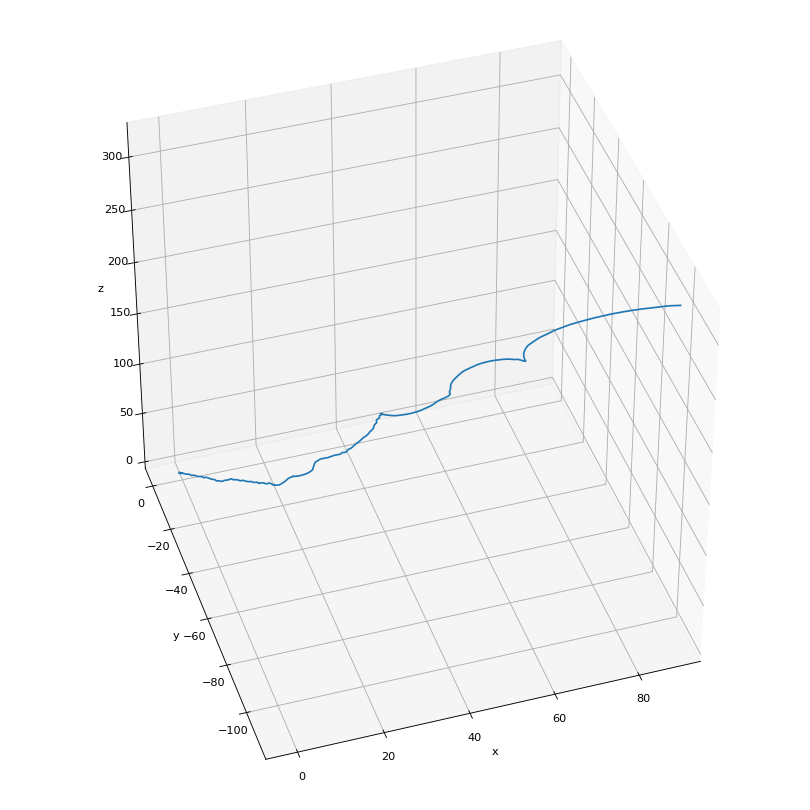

Text(0.5, 0, 'z')

In [10]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib nbagg
fig = pylab.figure(figsize = (10,10))
axes = Axes3D(fig)

axes.plot(pos[:,0], pos[:,1], pos[:,2])
# axes.set_xlim(-3,3)
# axes.set_ylim(-3,3)
# axes.set_zlim(-6,6)

plt.show()
    
axes.set_xlabel(u'x')
axes.set_ylabel(u'y')
axes.set_zlabel(u'z')


<IPython.core.display.Javascript object>


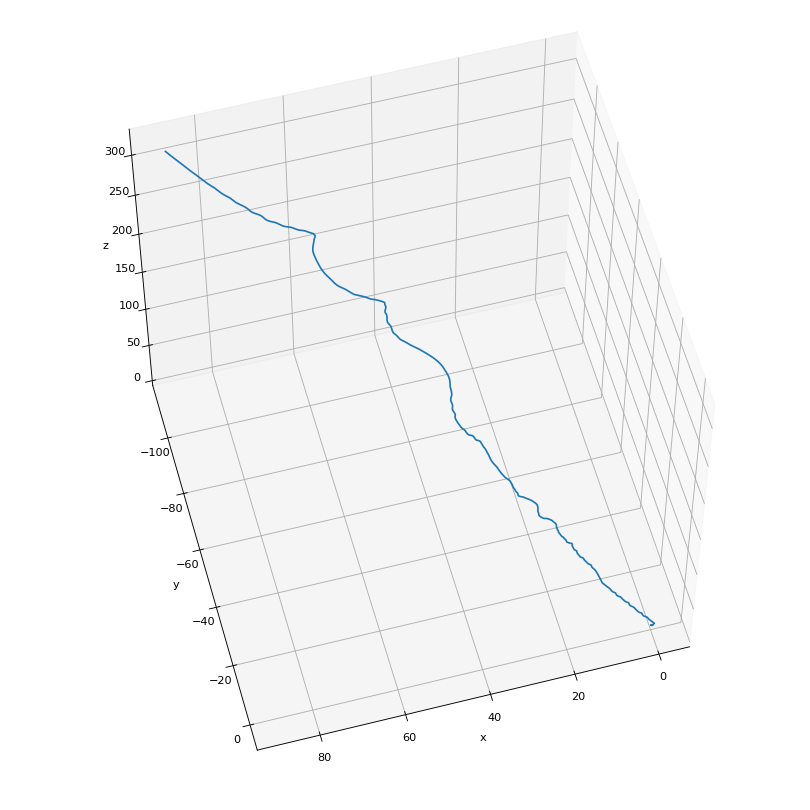

Text(0.5, 0, 'z')

In [27]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib nbagg
fig = pylab.figure(figsize = (10,10))
axes = Axes3D(fig)

axes.plot(pos[:,0], pos[:,1], pos[:,2])
# axes.set_xlim(-3,3)
# axes.set_ylim(-3,3)
# axes.set_zlim(-6,6)

plt.show()
    
axes.set_xlabel(u'x')
axes.set_ylabel(u'y')
axes.set_zlabel(u'z')


In [28]:
len(pos)-10

1249

In [59]:
madgwick = ahrs.filters.Madgwick()


In [60]:
ax_filt = ewma_filter(ax)
ay_filt = ewma_filter(ay)
az_filt = ewma_filter(az)
gx_filt = ewma_filter(gx)
gy_filt = ewma_filter(gy)
gz_filt = ewma_filter(gz)
mx_filt = ewma_filter(mx)
my_filt = ewma_filter(my)
mz_filt = ewma_filter(mz)

In [63]:
Q = np.tile([1., 0., 0., 0.], (len(ax), 1)) # Allocate an array for all quaternions
d2g = ahrs.common.DEG2RAD   # Constant to convert degrees to radians

In [65]:
for t in range(1, len(ax)):
#     print(t)
    Q[t] = madgwick.updateMARG(d2g*np.array([gx_filt[t], gy_filt[t], gz_filt[t]]), 
                               np.array([ax_filt[t], ay_filt[t], az_filt[t]]), 
                               np.array([mx_filt[t], my_filt[t], mz_filt[t]]),
                              Q[t-1])
# plt.plot(Q)
# plt.show()

In [66]:
a_rotate = np.zeros((len(ax), 3))

for i in range(len(ax)):
    RQ = ahrs.common.orientation.q2R(Q[i])
    a_rotate[i] = RQ@np.array([ax_filt[i], ay_filt[i], az_filt[i]])


In [67]:
# plt.plot(a_rotate[-6000:]*9.8*0.001)
plt.show()                    

In [68]:
plt.plot(moving_average(a_rotate)[-6000:])

TypeError: plot() missing 1 required positional argument: 'ys'

In [69]:
plt.hist(time[1:] - time[:-1], bins = 100, range=(0, 0.05))
plt.show()

In [70]:
a_rotate_filt = moving_average(a_rotate)

In [71]:
vxyz_mad = np.zeros((len(ax), 3))
xyz_mad = np.zeros((len(ax), 3))
xyz_mad_correct = np.zeros((len(ax), 3))
start_point= 100
for i in range(start_point, len(a_rotate)):
    vxyz_mad[i] = vxyz_mad[i-1] + 0.001*9.8*(a_rotate[i] - a_rotate.mean(axis = 0))*0.01
    
vxyz_mad_correct = moving_average(vxyz_mad, N = 100)
for i in range(start_point, len(a_rotate)):
    xyz_mad[i] = xyz_mad[i-1] + (vxyz_mad[i] - vxyz_mad.mean(axis = 0)) * 0.01

    xyz_mad_correct[i] = xyz_mad_correct[i-1] + (vxyz_mad_correct[i] - vxyz_mad_correct.mean(axis = 0)) * 0.01

In [72]:
plt.plot(vxyz_mad_correct)

TypeError: plot() missing 1 required positional argument: 'ys'

In [73]:
plt.plot(vxyz_mad)

TypeError: plot() missing 1 required positional argument: 'ys'

In [74]:
plt.plot(xyz_mad)
plt.show()

TypeError: plot() missing 1 required positional argument: 'ys'

In [75]:
plt.plot(xyz_mad_correct)
plt.show()

TypeError: plot() missing 1 required positional argument: 'ys'

In [76]:
plt.plot(vxyz_mad)
plt.plot(vxyz_mad_correct)

TypeError: plot() missing 1 required positional argument: 'ys'

In [77]:
file = pd.read_csv("C:/Files/parkinson/PatientDataV2/patient52/52/ex14_52.csv")
# plt.hist(np.sqrt(file['acc_x, mg']**2 + file['acc_y, mg']**2 + file['acc_z, mg']**2)/1000, bins= 100)

In [21]:
ax_filt = ewma_filter(ax)
ay_filt = ewma_filter(ay)
az_filt = ewma_filter(az)
gx_filt = ewma_filter(gx)
gy_filt = ewma_filter(gy)
gz_filt = ewma_filter(gz)
mx_filt = ewma_filter(mx)
my_filt = ewma_filter(my)
mz_filt = ewma_filter(mz)

Text(0.5, 1.0, 'z')

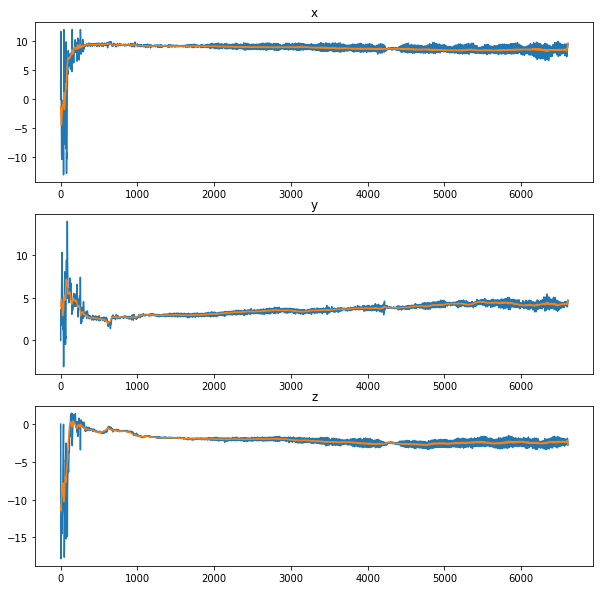

In [22]:
f, (axx, axy, axz) = plt.subplots(3,1, figsize= (10,10))
axx.plot(0.0098*ax)
axx.plot(0.0098*ax_filt)
axx.set_title('x')
axy.plot(0.0098*ay)
axy.plot(0.0098*ay_filt)
axy.set_title('y')
axz.plot(0.0098*az)
axz.plot(0.0098*az_filt)
axz.set_title('z')


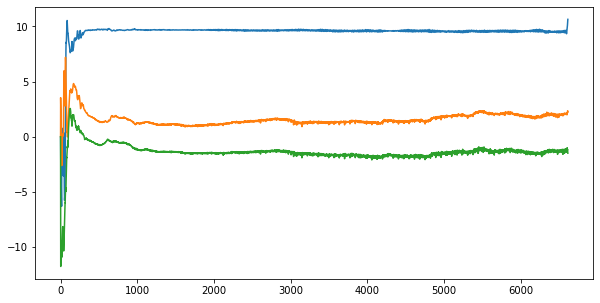

In [23]:
a_rotate = np.zeros((len(ax), 3))
theta = np.zeros(len(ax))
phi = np.zeros(len(ax))
psi = np.zeros(len(ax))

theta_acc = np.zeros(len(ax))
phi_acc = np.zeros(len(ax))
psi_acc = np.zeros(len(ax))

theta_gyr = np.zeros(len(ax))
phi_gyr = np.zeros(len(ax))
psi_gyr = np.zeros(len(ax))

for i in range(1, len(ax_filt)):
#     print(i)
    theta_acc[i-1] = np.arctan(az_filt[i-1]/ax_filt[i-1])
    psi_acc[i-1] = np.arctan(ay_filt[i-1]/np.sqrt(ax_filt[i-1]**2 + az_filt[i-1]**2))
    phi_acc[i-1] = 0
    dt = time[i]-time[i-1]
    
    phi_gyr[i-1]   = gx_filt[i-i]*dt*np.pi/180
    theta_gyr[i-1] = gy_filt[i-i]*dt*np.pi/180
    psi_gyr[i-1]   = gz_filt[i-i]*dt*np.pi/180
    theta, phi, psi = update_angles(theta, phi, psi,
                                    theta_acc, psi_acc, phi_acc,
                                    phi_gyr, theta_gyr, psi_gyr, i, a = 0.1)
#     R = transform.Rotation(quarternion(psi[i]/2,theta[i]/2,phi[i]/2))
#     R = R.from_euler()
#     RQ = R.as_dcm()
    
    RQ2 = RotationMatrixFromQuarternion(quarternion(psi[i]/2,phi[i]/2,theta[i]/2))
#     print(np.linalg.norm((RQ- RQ2)))
    a_rotate[i] = RQ2@np.array([ax_filt[i-1], ay_filt[i-1], az_filt[i-1]])
plt.figure(figsize = (10,5))
plt.plot(0.0098*a_rotate )

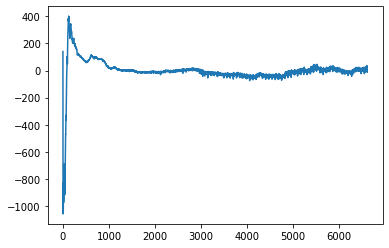

In [24]:
plt.plot((a_rotate - a_rotate.mean(axis = 0))[:, 2])
plt.show()

In [25]:
a_rotate_filt = moving_average(a_rotate)

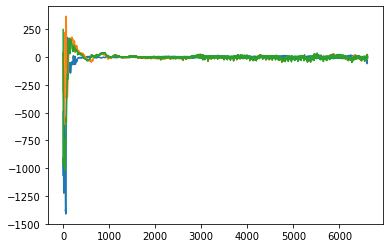

In [26]:
plt.plot(a_rotate_filt)
plt.show()

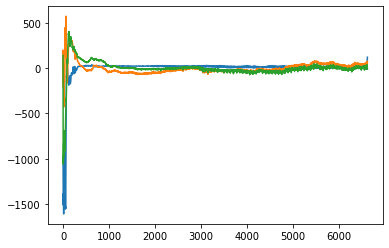

In [27]:
plt.plot(a_rotate - np.array([0,0,a_rotate.mean(axis = 0)][2]))

In [29]:
vxyz = np.zeros((len(ax), 3))
xyz = np.zeros((len(ax), 3))
xyz_correct = np.zeros((len(ax), 3))
start_point= 100
for i in range(start_point, len(a_rotate)):
    vxyz[i] = vxyz[i-1] + 0.001*9.8*(a_rotate_filt[i] - a_rotate_filt.mean(axis = 0))*(time[i] - time[i-1])
#     xyz_correct[i] = xyz_correct[i-1] + vxyz_correct[i] * (time[i] - time[i-1])

In [30]:
# offset = (vxyz[-1] - vxyz[start_point])/(time[-1] - time[start_point])
# vxyz_correct = np.zeros((len(ax), 3))
# for i in range(start_point, len(a_rotate)):
#     vxyz_correct[i] = vxyz[i] - (time[i] - time[start_point] )*offset
vxyz_correct = moving_average(vxyz)

In [31]:
for i in range(start_point, len(a_rotate)):
    xyz[i] = xyz[i-1] + vxyz[i] * (time[i] - time[i-1])
    
    xyz_correct[i] = xyz_correct[i-1] + vxyz_correct[i] * (time[i] - time[i-1])

In [32]:
xyz.shape

(6613, 3)

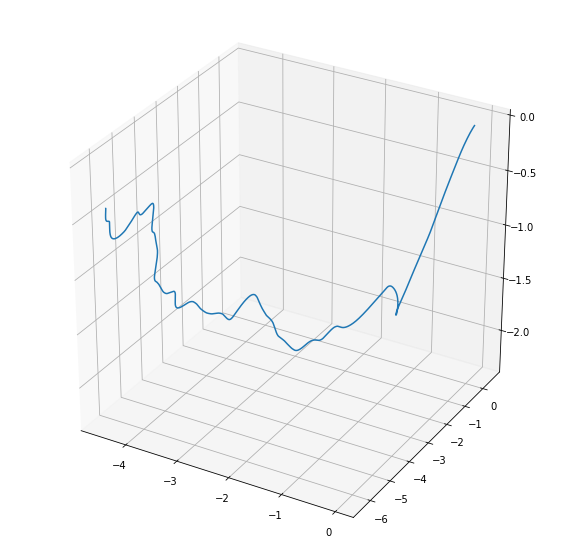

In [33]:
fig = plt.figure(figsize= (10, 10))
start = 0
end = -1
axes = fig.add_subplot(111, projection='3d')
axes.plot(xyz_correct[start:end,2], xyz_correct[start:end,0], xyz_correct[start:end,1])
plt.show()

In [34]:
xyz_mad_correct.shape, time.shape

((1259, 3), (6613,))

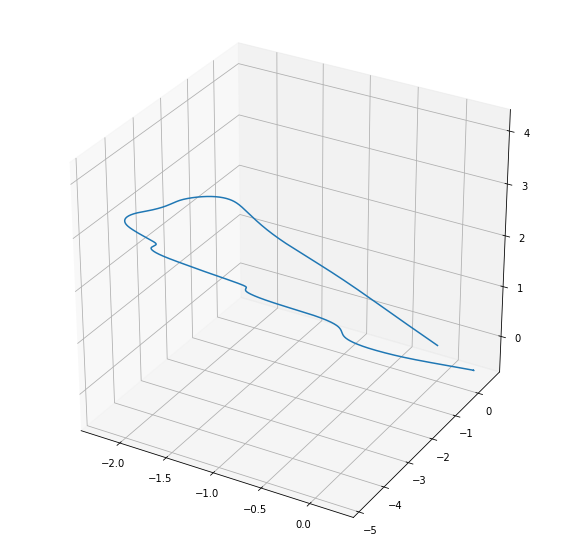

In [35]:
fig = plt.figure(figsize= (10, 10))
start = -6000
end = -1
axes = fig.add_subplot(111, projection='3d')
axes.plot(xyz_mad_correct[start:end,0], xyz_mad_correct[start:end,1], xyz_mad_correct[start:end, 2])
plt.show()

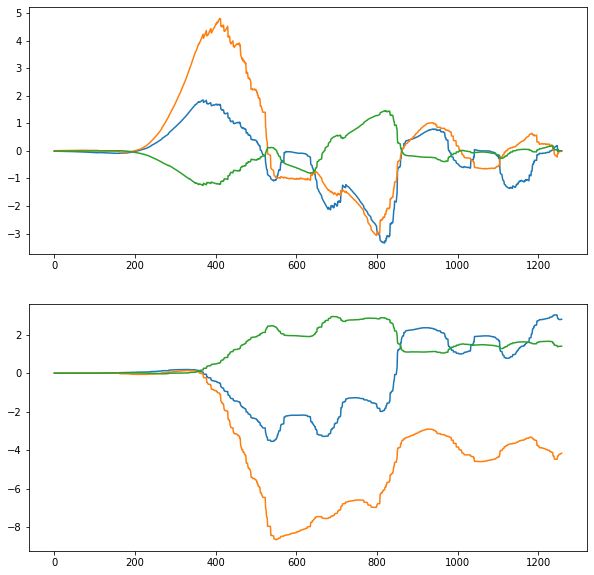

In [78]:
# i = 2
f, (ax0, ax1) = plt.subplots(2, 1, figsize = (10,10))
ax0.plot(vxyz_correct)
ax1.plot(vxyz)
plt.show()

<IPython.core.display.Javascript object>


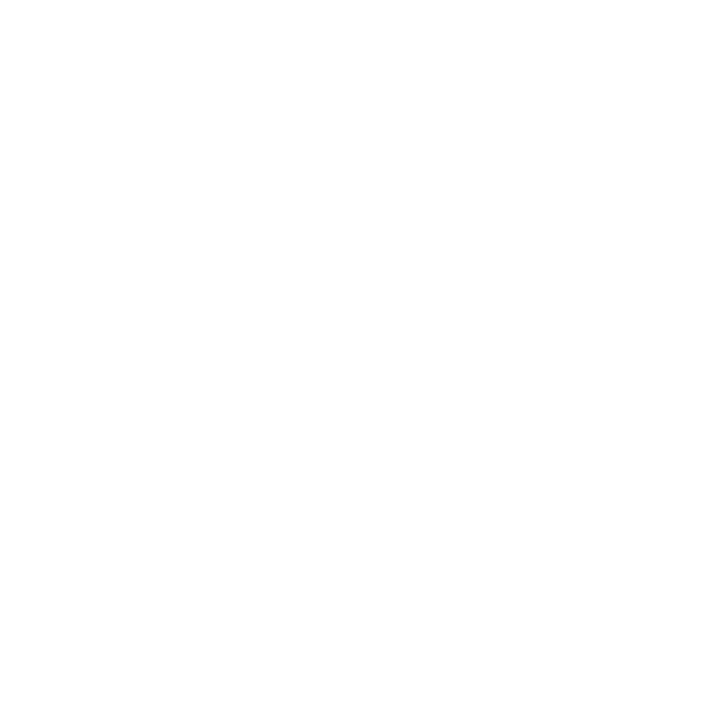

<IPython.core.display.Javascript object>


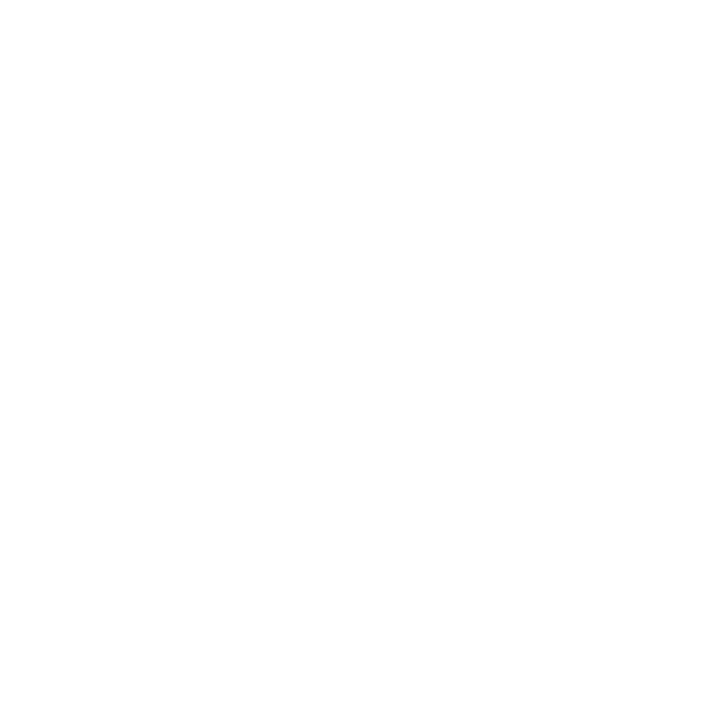

In [82]:
# i = 2
f, (ax0, ax1) = plt.subplots(2, 1, figsize = (10,10))
ax0.plot(xyz_correct)
ax1.plot(xyz)
plt.show()

In [80]:
xyz[:,2]

array([ 0.        ,  0.        ,  0.        , ..., 48.48349069,
       48.66829368, 48.82562059])

<IPython.core.display.Javascript object>


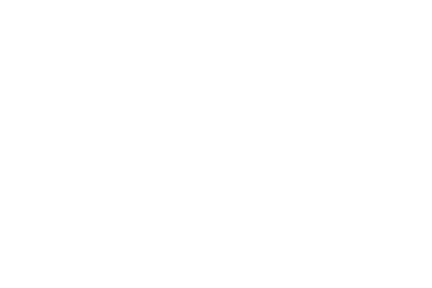

Text(0.5, 0, 'z')

<IPython.core.display.Javascript object>


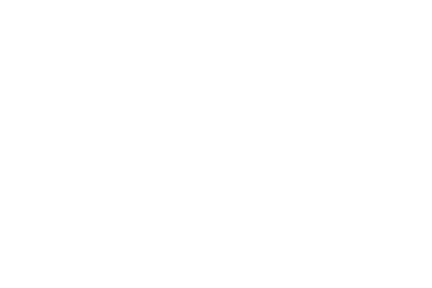

In [81]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib nbagg
fig = pylab.figure()
axes = Axes3D(fig)

axes.plot(xyz_correct[:,0], xyz_correct[:,1], xyz_correct[:,2])


plt.show()
    
axes.set_xlabel(u'x')
axes.set_ylabel(u'y')
axes.set_zlabel(u'z')

def init():
    line.set_data(z4)
    line.set_3d_properties([0, 0])
    return line

def update_lines(num):
    num = (num + 1) % size
    phi = num / size * 2 * np.pi
    line.set_data([[0, np.cos(phi)],[0, np.sin(2*phi)]])
    line.set_3d_properties([0, np.cos(4*phi)])
    return line

g = np.zeros(1000)
for k in range(1000):
    if(k%200<190):
        g[k] = 0.01
m = 0.511
p0 = 10
ap=0
E = 0.01
b = 0.01
a = range(1000)
fig = pylab.figure()
axes = Axes3D(fig)

axes.plot(xyz_correct[:,0], xyz_correct[:,1], xyz_correct[:,2])


plt.show()
    
axes.set_xlabel(u'x')
axes.set_ylabel(u'y')
axes.set_zlabel(u'z')
# pylab.show()    